In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!ls

__notebook__.ipynb


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catalyst import dl, utils

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
directories = ['../input/csc4851-homework4/birds_400/test',
                                '../input/csc4851-homework4/birds_400/train',
                                '../input//csc4851-homework4/birds_400/valid']

for dir in directories:
    label = []
    path = []
    for dirname, _,filenames in os.walk(dir):
        for filename in filenames:
            label.append(os.path.split(dirname)[1])
            path.append(os.path.join(dirname,filename))
    if dir == directories[0]:
        df_test = pd.DataFrame(columns=['path','label'])
        df_test['path']=path
        df_test['label']=label
    elif dir == directories[1]:
        df_train = pd.DataFrame(columns=['path','label'])
        df_train['path']=path
        df_train['label']=label        
    elif dir == directories[2]:
        df_valid = pd.DataFrame(columns=['path','label'])
        df_valid['path']=path
        df_valid['label']=label


In [5]:
df_train.head()

,path,label
0,../input/csc4851-homework4/birds_400/train/WAT...,WATTLED CURASSOW
1,../input/csc4851-homework4/birds_400/train/WAT...,WATTLED CURASSOW
2,../input/csc4851-homework4/birds_400/train/WAT...,WATTLED CURASSOW
3,../input/csc4851-homework4/birds_400/train/WAT...,WATTLED CURASSOW
4,../input/csc4851-homework4/birds_400/train/WAT...,WATTLED CURASSOW


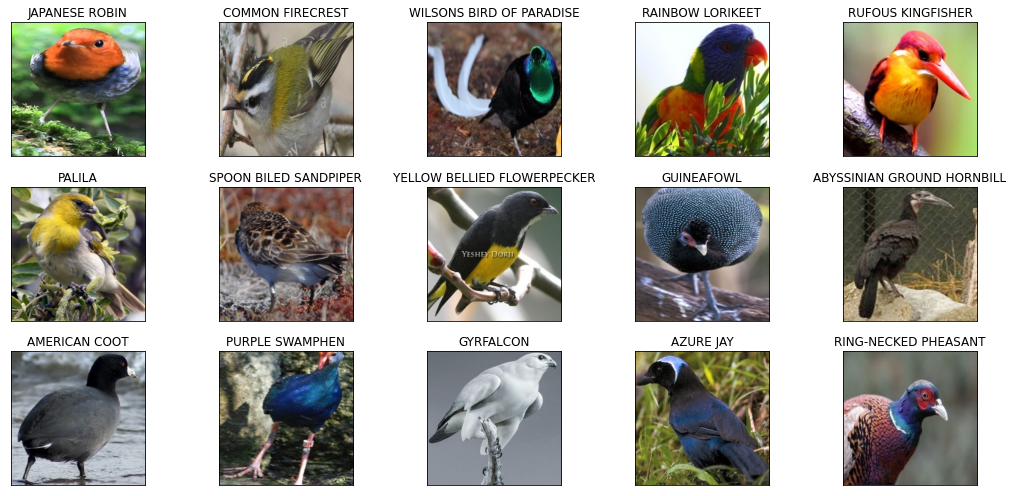

In [6]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

df_sample = df_train.sample(15)
df_sample.reset_index(drop=True, inplace=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_sample.path[i]))
    ax.set_title(df_sample.label[i])
plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [8]:
# Hyper Parameters 
# input_size = 3*3*64
num_classes = 400
# num_epochs = 5
batch_size = 25
learning_rate = 0.01

In [9]:
transform_dict = transforms.Compose([transforms.Resize((120, 120)),
        transforms.RandomResizedCrop(120),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.4])
        ]) #normalize! 0.5? //input_size not same as dimensions // 

train_data = torchvision.datasets.ImageFolder(root=directories[1], transform=transform_dict)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

test_data = torchvision.datasets.ImageFolder(root=directories[0], transform=transform_dict)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

valid_data = torchvision.datasets.ImageFolder(root=directories[2], transform=transform_dict)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=5, shuffle=False, drop_last=False, num_workers=4)

In [10]:
class Birdinator(nn.Module): # add model.train, model.eval
    def __init__(self, num_classes):
        super(Birdinator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*6*6, 256)
        self.fc2 = nn.Linear(256, 400)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.pool1(x))
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.pool2(x))
        # print(x.shape)

        x = x.view(-1,64*6*6)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Birdinator(num_classes)

In [11]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
epochs = 20
for epoch in range(epochs):

    running_loss = 0.0
    model.train()
    model.cuda()
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(torch.device("cuda"))
        labels = labels.to(torch.device("cuda"))
        optimizer.zero_grad()
        y_pred =  model(batch)
        cel = nn.CrossEntropyLoss()
        loss = cel(y_pred,labels)
        loss.backward()
        optimizer.step()
      
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 5.990
[1,  1000] loss: 5.982
[1,  1500] loss: 5.943
[1,  2000] loss: 5.847
[2,   500] loss: 5.684
[2,  1000] loss: 5.577
[2,  1500] loss: 5.484
[2,  2000] loss: 5.396
[3,   500] loss: 5.238
[3,  1000] loss: 5.156
[3,  1500] loss: 5.096
[3,  2000] loss: 5.041
[4,   500] loss: 4.935
[4,  1000] loss: 4.898
[4,  1500] loss: 4.832
[4,  2000] loss: 4.799
[5,   500] loss: 4.705
[5,  1000] loss: 4.668
[5,  1500] loss: 4.616
[5,  2000] loss: 4.608
[6,   500] loss: 4.504
[6,  1000] loss: 4.514
[6,  1500] loss: 4.480
[6,  2000] loss: 4.424
[7,   500] loss: 4.392
[7,  1000] loss: 4.365
[7,  1500] loss: 4.322
[7,  2000] loss: 4.298
[8,   500] loss: 4.257
[8,  1000] loss: 4.218
[8,  1500] loss: 4.217
[8,  2000] loss: 4.201
[9,   500] loss: 4.115
[9,  1000] loss: 4.137
[9,  1500] loss: 4.096
[9,  2000] loss: 4.108
[10,   500] loss: 4.054
[10,  1000] loss: 4.000
[10,  1500] loss: 4.056
[10,  2000] loss: 3.998
[11,   500] loss: 3.956
[11,  1000] loss: 3.936
[11,  1500] loss: 3.932
[11,

In [13]:

PATH = "./save_model"
torch.save(model.state_dict(), PATH)

model = Birdinator(num_classes)

# model.load_state_dict(torch.load(PATH))

In [14]:
PATH = "./save_model"
model.load_state_dict(torch.load(PATH))

dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images)

In [15]:
correct = 0
total = 0
cel = nn.CrossEntropyLoss()
birds = []
id = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(valid_loader):
      if i % 100 == 99:
        print("1/4...")
      images, labels = data
      # calculate outputs by running images through the network
      outputs = model(images)
      loss = cel(outputs,labels)
      id.append(i)
      birds.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of this network on validation images: %d %%' % (100 * correct / total))


1/4...
1/4...
1/4...
1/4...
Accuracy of this network on validation images: 28 %


In [16]:
id = [i for i in range(400)]
submission_list = np.array([id, birds])
submission_list = np.transpose(submission_list)
submission = pd.DataFrame({'id': id, 'birds': birds})
submission.to_csv('submission.csv', index=False)
submission.tail()

,id,birds
395,395,3.932196
396,396,2.159293
397,397,1.926451
398,398,1.632518
399,399,3.312271
